# Assignment - 8: Apply Decision Trees on Donors Choose dataset

This exercise is to apply Decision Trees on Donors Choose dataset and predict approval of a new project proposal.

Relevant Information : The dataset is divided into two files -
1. train.csv file which contains information regarding projects, schools and teachers who submitted the projects. 
2. resources.csv which provides information about the resources required for each project.




### OBJECTIVE : The goal is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school using Decision Trees.



In [2]:
# Importing the required libraries
# Warning reference : https://stackoverflow.com/questions/41658568/chunkize-warning-while-installing-gensim

%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category = UserWarning , module = 'gensim')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1. Reading the data

In [3]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

print("\nNumber of data points in train data", project_data.shape)
print('-'*120)
print("The attributes of data :", project_data.columns.values)



Number of data points in train data (109248, 17)
------------------------------------------------------------------------------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 17 columns):
Unnamed: 0                                      109248 non-null int64
id                                              109248 non-null object
teacher_id                                      109248 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109248 non-null object
project_submitted_datetime                      109248 non-null object
project_grade_category                          109248 non-null object
project_subject_categories                      109248 non-null object
project_subject_subcategories                   109248 non-null object
project_title                                   109248 non-null object
project_essay_1                                 109248 non-null object
project_essay_2                                 109248 non-null object
project_essay_3                       

## NOTE:
1. We have a total of 109248 datapoints and 17 columns.
2. Now we have to sort the data according to date and time so as to have a better prediction on the future data (Test data).
3. As we can see there are null points for project_essay_3 and project_essay_4. Only 3758 points are not null.
4. In teacher_prefix there are 109245 points which means 3 points are null.

### `Sorting according to date`

In [5]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

print(cols)

['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state', 'Date', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories', 'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'project_resource_summary', 'teacher_number_of_previously_posted_projects', 'project_is_approved']


In [6]:
# Dropping the Unnamed column

project_data.drop('Unnamed: 0', axis=1, inplace=True)

### `Adding the price and quantity column from resource_data to the project_data`

In [7]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

# Deleting the resource data variable
del resource_data

## NOTE:
1. As we can see that the price and the quantity column has been added to the project_data
2. This is where the preprocessing will start.
3. we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - essay : text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

## 2. Preprocessing Data

### `project_subject_categories`

In [8]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### `project_subject_subcategories`

In [9]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## Text Preprocessing

## `Essay`

In [10]:
# Combining all the essay
# merge two column text dataframe: 

project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [11]:
project_data['essay'].describe()

count                                                109248
unique                                               108986
top       At our school, we strive to always be \"Chargi...
freq                                                      5
Name: essay, dtype: object

In [12]:
# Making the decontracted function

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


### STOPWORDS
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


# Combining all the above statements 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:20<00:00, 1351.54it/s]


<h2><font color='red'>project_title</font></h2>

In [13]:
project_data['project_title'].describe()

count               109248
unique              100851
top       Flexible Seating
freq                   234
Name: project_title, dtype: object

In [14]:
# Project_title

# Combining all the above statements 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:03<00:00, 28802.15it/s]


### Replacing the columns with new cleaned columns - Project_title and Essay

In [15]:
# Adding processed essay columns in place of previous essays columns and dropping the previous columns

## ESSAY

project_data['clean_essays'] = preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)
project_data.drop(['essay'], axis=1, inplace=True)

In [16]:
## Project_title

# Adding processed project_title columns in place of previous project_title column and dropping the previous column

project_data['clean_titles'] = preprocessed_titles

project_data.drop(['project_title'], axis=1, inplace=True)


### Dropping the nan rows present in teacher_prefix

In [17]:
# Dropping NAN row
# https://stackoverflow.com/questions/46091924/python-how-to-drop-a-row-whose-particular-column-is-empty-nan

project_data.dropna(axis = 0, inplace = True, subset = ['teacher_prefix'])

In [18]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109245 entries, 0 to 109247
Data columns (total 15 columns):
id                                              109245 non-null object
teacher_id                                      109245 non-null object
teacher_prefix                                  109245 non-null object
school_state                                    109245 non-null object
Date                                            109245 non-null datetime64[ns]
project_grade_category                          109245 non-null object
project_resource_summary                        109245 non-null object
teacher_number_of_previously_posted_projects    109245 non-null int64
project_is_approved                             109245 non-null int64
price                                           109245 non-null float64
quantity                                        109245 non-null int64
clean_categories                                109245 non-null object
clean_subcategories            

## NOTE:
    - Till now we have preprocessed the data. 
    - Now we have to split the data and vectorize the data for BOW, TF-IDF, Avg W2V and TFIDF weighted W2Vec

<h1><font color='red'>************************************ASSIGNMENT************************************</font></h1>

<h2>3. Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [19]:
# Creating label and feature data frame : Label- y, Features- X

y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data

print(y.shape)
print(X.shape)

(109245,)
(109245, 14)


In [20]:
## train test cross-validation split
# Referance : https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

## NOTE:
    - This `stratify` parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

    - For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In [21]:
## Shape of the matrices

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(49039, 14) (49039,)
(24155, 14) (24155,)
(36051, 14) (36051,)


## NOTE:
1. We will now use the train data for training our model, cv data to validate the model and perform testing on the test data

<h2>4. Make Data Model Ready: encoding numerical, categorical features</h2>

## `Vectorizing Categorical Features`

### `1. clean_categories`

In [22]:
# We use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_clean_categories = CountVectorizer()

# We will fit the train data only
vectorizer_clean_categories.fit(X_train['clean_categories'].values) 


# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_category = vectorizer_clean_categories.transform(X_train['clean_categories'].values)
X_cv_clean_category = vectorizer_clean_categories.transform(X_cv['clean_categories'].values)
X_test_clean_category = vectorizer_clean_categories.transform(X_test['clean_categories'].values)

print("Clean categories are vectorized\n")
print(X_train_clean_category.shape, y_train.shape)
print(X_cv_clean_category.shape, y_cv.shape)
print(X_test_clean_category.shape, y_test.shape)

print(vectorizer_clean_categories.get_feature_names())

Clean categories are vectorized

(49039, 9) (49039,)
(24155, 9) (24155,)
(36051, 9) (36051,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### `2. clean_subcategories`

In [23]:
vectorizer_clean_subcategories = CountVectorizer()

# We will fit the train data only
vectorizer_clean_subcategories.fit(X_train['clean_subcategories'].values) 


# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories = vectorizer_clean_subcategories.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories = vectorizer_clean_subcategories.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories = vectorizer_clean_subcategories.transform(X_test['clean_subcategories'].values)


print("Clean_subcategories are vectorized\n")
print(X_train_clean_subcategories.shape, y_train.shape)
print(X_cv_clean_subcategories.shape, y_cv.shape)
print(X_test_clean_subcategories.shape, y_test.shape)
print(vectorizer_clean_subcategories.get_feature_names())

Clean_subcategories are vectorized

(49039, 30) (49039,)
(24155, 30) (24155,)
(36051, 30) (36051,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### `3. teacher_prefix`

In [24]:
vectorizer_teacher_prefix = CountVectorizer()

# We will fit the train data only
vectorizer_teacher_prefix.fit(X_train['teacher_prefix'].values)


# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix = vectorizer_teacher_prefix.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix = vectorizer_teacher_prefix.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix = vectorizer_teacher_prefix.transform(X_test['teacher_prefix'].values)


print("Teacher_prefix are vectorized\n")
print(X_train_teacher_prefix.shape, y_train.shape)
print(X_cv_teacher_prefix.shape, y_cv.shape)
print(X_test_teacher_prefix.shape, y_test.shape)
print(vectorizer_teacher_prefix.get_feature_names())


Teacher_prefix are vectorized

(49039, 5) (49039,)
(24155, 5) (24155,)
(36051, 5) (36051,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### `4. school_state`

In [25]:
vectorizer_school_state = CountVectorizer()

# We will fit the train data only
vectorizer_school_state.fit(X_train['school_state'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_school_state = vectorizer_school_state.transform(X_train['school_state'].values)
X_cv_school_state = vectorizer_school_state.transform(X_cv['school_state'].values)
X_test_school_state = vectorizer_school_state.transform(X_test['school_state'].values)

print("School_state are vectorized\n")
print(X_train_school_state.shape, y_train.shape)
print(X_cv_school_state.shape, y_cv.shape)
print(X_test_school_state.shape, y_test.shape)
print(vectorizer_school_state.get_feature_names())


School_state are vectorized

(49039, 51) (49039,)
(24155, 51) (24155,)
(36051, 51) (36051,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### `5. project_grade_category`

In [26]:
#This step is to intialize a vectorizer with vocab from train data

# Creating the list of grades

grades = list(set(project_data['project_grade_category'].values))

# we use count vectorizer to convert the values into one hot encoded features
# We will fit the train data only
vectorizer_grade_category = CountVectorizer(vocabulary = grades, lowercase=False, binary=True)
vectorizer_grade_category.fit(X_train['project_grade_category'].values) 


# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade = vectorizer_grade_category.transform(X_train['project_grade_category'].values)
X_cv_project_grade = vectorizer_grade_category.transform(X_cv['project_grade_category'].values)
X_test_project_grade = vectorizer_grade_category.transform(X_test['project_grade_category'].values)

print("Project_grade_category are vectorized\n")
print(X_train_project_grade.shape, y_train.shape)
print(X_cv_project_grade.shape, y_cv.shape)
print(X_test_project_grade.shape, y_test.shape)
print(vectorizer_grade_category.get_feature_names())


Project_grade_category are vectorized

(49039, 4) (49039,)
(24155, 4) (24155,)
(36051, 4) (36051,)
['Grades 6-8', 'Grades 3-5', 'Grades PreK-2', 'Grades 9-12']


## `Standardizing Numerical features`

### `1. price`

In [27]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

price_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")


# Now standardize the data with above mean and variance.
X_train_price = price_scalar.transform(X_train['price'].values.reshape(-1,1))
X_cv_price = price_scalar.transform(X_cv['price'].values.reshape(-1,1))
X_test_price = price_scalar.transform(X_test['price'].values.reshape(-1,1))

print("Price is standardized\n")
print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)


Mean : 295.5121276942842, Standard deviation : 363.55082629076
Price is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `2. teacher_number_of_previously _posted_projects`

In [28]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

# https://stackoverflow.com/questions/29086398/sklearn-turning-off-warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.preprocessing import StandardScaler
previous_post_scalar = StandardScaler(with_mean = False)

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

# We will fit the train data only
# finding the mean and standard deviation of this data
previous_post_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 
print(f"Mean : {previous_post_scalar.mean_[0]}, Standard deviation : {np.sqrt(previous_post_scalar.var_[0])}")

X_train_previous_projects = previous_post_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_previous_projects = previous_post_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previous_projects = previous_post_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("Teacher_number_of_previously_posted_projects is standardized\n")
print(X_train_previous_projects.shape, y_train.shape)
print(X_cv_previous_projects.shape, y_cv.shape)
print(X_test_previous_projects.shape, y_test.shape)


Mean : 11.264075531719651, Standard deviation : 28.19867950532447
Teacher_number_of_previously_posted_projects is standardized

(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


### `3. quantity`

In [29]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

# https://stackoverflow.com/questions/29086398/sklearn-turning-off-warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.preprocessing import StandardScaler
quantity_scalar = StandardScaler(with_mean = False)

# We will fit the train data only
# finding the mean and standard deviation of this data
quantity_scalar.fit(X_train['quantity'].values.reshape(-1,1)) 
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")


# Now standardize the data with above maen and variance.
X_train_quantity = quantity_scalar.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity = quantity_scalar.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity = quantity_scalar.transform(X_test['quantity'].values.reshape(-1,1))


print("quantity is standardized")
print(X_train_quantity.shape, y_train.shape)
print(X_cv_quantity.shape, y_cv.shape)
print(X_test_quantity.shape, y_test.shape)


Mean : 17.081200677012173, Standard deviation : 26.562809250378823
quantity is standardized
(49039, 1) (49039,)
(24155, 1) (24155,)
(36051, 1) (36051,)


<h2>5. Make Data Model Ready: encoding eassay, and project_title</h2>

# `BOW`

### `1. clean_essay`

In [30]:
%%time
# Vectorizing the essay column

from sklearn.feature_extraction.text import CountVectorizer

# We are considering only the words which appeared in at least 10 documents(rows or projects).
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Taking top 5000 features

# Creating the vectorizer with bi-grams 
vectorizer_bow_essay = CountVectorizer(min_df=10)

# We will fit the train data only
vectorizer_bow_essay.fit(X_train['clean_essays'].values) 

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_bow_essay.transform(X_train['clean_essays'].values)
X_cv_essay_bow = vectorizer_bow_essay.transform(X_cv['clean_essays'].values)
X_test_essay_bow = vectorizer_bow_essay.transform(X_test['clean_essays'].values)

print("Essay vectorized")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

Essay vectorized
(49039, 12055) (49039,)
(24155, 12055) (24155,)
(36051, 12055) (36051,)
Wall time: 25.4 s


### `2. clean_titles`

In [31]:
# Vectorizing the project_title column

# We are considering only the words which appeared in at least 10 documents(rows or projects).
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Taking top 5000 features

# Creating the vectorizer with bi-grams 
vectorizer_bow_title = CountVectorizer(min_df=10)

# We will fit the train data only
vectorizer_bow_title.fit(X_train['clean_titles'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_titles_bow = vectorizer_bow_title.transform(X_train['clean_titles'].values)
X_cv_titles_bow = vectorizer_bow_title.transform(X_cv['clean_titles'].values)
X_test_titles_bow = vectorizer_bow_title.transform(X_test['clean_titles'].values)

print("Project Titles vectorized")
print(X_train_titles_bow.shape, y_train.shape)
print(X_cv_titles_bow.shape, y_cv.shape)
print(X_test_titles_bow.shape, y_test.shape)

Project Titles vectorized
(49039, 2085) (49039,)
(24155, 2085) (24155,)
(36051, 2085) (36051,)


# `TF-IDF`

### `1. clean_essay`

In [30]:
%%time
# Vectorizing the essay column

from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the vectorizer with bi-grams 
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)

# We will fit the train data only
vectorizer_tfidf_essay.fit(X_train['clean_essays'].values)

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['clean_essays'].values)
X_cv_essay_tfidf = vectorizer_tfidf_essay.transform(X_cv['clean_essays'].values)
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['clean_essays'].values)


print("Essay vectorized")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

Essay vectorized
(49039, 12033) (49039,)
(24155, 12033) (24155,)
(36051, 12033) (36051,)
Wall time: 29 s


### `2. clean_titles`

In [31]:
%%time
# Vectorizing the project_title column

from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the vectorizer with bi-grams 
vectorizer_tfidf_titles = TfidfVectorizer(min_df=10)

# We will fit the train data only
vectorizer_tfidf_titles.fit(X_train['clean_titles'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_titles_tfidf = vectorizer_tfidf_titles.transform(X_train['clean_titles'].values)
X_cv_titles_tfidf = vectorizer_tfidf_titles.transform(X_cv['clean_titles'].values)
X_test_titles_tfidf = vectorizer_tfidf_titles.transform(X_test['clean_titles'].values)


print("Titles vectorized")
print(X_train_titles_tfidf.shape, y_train.shape)
print(X_cv_titles_tfidf.shape, y_cv.shape)
print(X_test_titles_tfidf.shape, y_test.shape)

Titles vectorized
(49039, 2085) (49039,)
(24155, 2085) (24155,)
(36051, 2085) (36051,)
Wall time: 1.69 s


# `Average W2V`

### `1. clean_essay`

In [30]:
%%time
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    
    
# average Word2Vec
# compute average word2vec
train_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_train['clean_essays'].values): # for each essay in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_w2v_vectors_essays.append(vector)
print("Train  vector")
print(len(train_w2v_vectors_essays))
print(len(train_w2v_vectors_essays[0]))
print('='*120)


# average Word2Vec
# compute average word2vec
test_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['clean_essays'].values): # for each essay in test data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_w2v_vectors_essays.append(vector)

print("Test vec")
print(len(test_w2v_vectors_essays))
print(len(test_w2v_vectors_essays[0]))
print('='*120)


# average Word2Vec
# compute average word2vec
cv_w2v_vectors_essays = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['clean_essays'].values): # for each essay in cv data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a essay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_w2v_vectors_essays.append(vector)

print("CV vec")
print(len(cv_w2v_vectors_essays))
print(len(cv_w2v_vectors_essays[0]))
print('='*120)


100%|██████████████████████████████████████████████████████████████████████████| 49039/49039 [00:21<00:00, 2288.54it/s]


Train  vector
49039
300


100%|██████████████████████████████████████████████████████████████████████████| 36051/36051 [00:15<00:00, 2280.39it/s]


Test vec
36051
300


100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:10<00:00, 2309.28it/s]


CV vec
24155
300
Wall time: 48.1 s


In [31]:
# Changing list to numpy arrays
train_w2v_vectors_essays = np.array(train_w2v_vectors_essays)
test_w2v_vectors_essays = np.array(test_w2v_vectors_essays)
cv_w2v_vectors_essays = np.array(cv_w2v_vectors_essays)

print("Essay vectorized")
print(train_w2v_vectors_essays.shape, y_train.shape)
print(cv_w2v_vectors_essays.shape, y_cv.shape)
print(test_w2v_vectors_essays.shape, y_test.shape)

Essay vectorized
(49039, 300) (49039,)
(24155, 300) (24155,)
(36051, 300) (36051,)


### `2. clean_titles`

In [32]:
%%time
# average Word2Vec
# compute average word2vec 
train_w2v_vectors_titles = []; # the avg-w2v for each title is stored in this list
for sentence in tqdm(X_train['clean_titles'].values): # for each title in training data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the title
    for word in sentence.split(): # for each word in a title
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_w2v_vectors_titles.append(vector)
print("Train  vector")
print(len(train_w2v_vectors_titles))
print(len(train_w2v_vectors_titles[0]))
print('='*120)

# average Word2Vec
# compute average word2vec 
test_w2v_vectors_titles = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_test['clean_titles'].values): # for each essay in test data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the title
    for word in sentence.split(): # for each word in a title
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_w2v_vectors_titles.append(vector)

print("Test vec")
print(len(test_w2v_vectors_titles))
print(len(test_w2v_vectors_titles[0]))
print('='*120)

# average Word2Vec
# compute average word2vec 
cv_w2v_vectors_titles = []; # the avg-w2v for each essay is stored in this list
for sentence in tqdm(X_cv['clean_titles'].values): # for each essay in cv data
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the title
    for word in sentence.split(): # for each word in a title
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_w2v_vectors_titles.append(vector)

print("CV vec")
print(len(cv_w2v_vectors_titles))
print(len(cv_w2v_vectors_titles[0]))
print('='*120)

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:01<00:00, 42372.34it/s]


Train  vector
49039
300


100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 47381.87it/s]


Test vec
36051
300


100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 47053.05it/s]


CV vec
24155
300
Wall time: 2.47 s


In [33]:
# Changing list to numpy arrays
train_w2v_vectors_titles = np.array(train_w2v_vectors_titles)
test_w2v_vectors_titles = np.array(test_w2v_vectors_titles)
cv_w2v_vectors_titles = np.array(cv_w2v_vectors_titles)

print("Title vectorized")
print(train_w2v_vectors_titles.shape, y_train.shape)
print(cv_w2v_vectors_titles.shape, y_cv.shape)
print(test_w2v_vectors_titles.shape, y_test.shape)

Title vectorized
(49039, 300) (49039,)
(24155, 300) (24155,)
(36051, 300) (36051,)


# `TF-IDF weighted W2V`

### `1. clean_essay`

In [34]:
%%time
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    

# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['clean_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essays.append(vector)

print("Train matrix:")
print(len(train_tfidf_w2v_essays))
print(len(train_tfidf_w2v_essays[0]))
print('='*120)


cv_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_essays.append(vector)

print("CV matrix:")
print(len(cv_tfidf_w2v_essays))
print(len(cv_tfidf_w2v_essays[0]))
print('='*120)


test_tfidf_w2v_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)

print("Test matrix:")
print(len(test_tfidf_w2v_essays))
print(len(test_tfidf_w2v_essays[0]))
print('='*120)

100%|███████████████████████████████████████████████████████████████████████████| 49039/49039 [02:16<00:00, 359.53it/s]


Train matrix:
49039
300


100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [01:02<00:00, 387.69it/s]


CV matrix:
24155
300


100%|███████████████████████████████████████████████████████████████████████████| 36051/36051 [01:33<00:00, 385.59it/s]


Test matrix:
36051
300
Wall time: 5min 3s


In [35]:
# Changing list to numpy arrays
train_tfidf_w2v_essays = np.array(train_tfidf_w2v_essays)
test_tfidf_w2v_essays = np.array(test_tfidf_w2v_essays)
cv_tfidf_w2v_essays = np.array(cv_tfidf_w2v_essays)

print("Essay vectorized")
print(train_tfidf_w2v_essays.shape, y_train.shape)
print(cv_tfidf_w2v_essays.shape, y_cv.shape)
print(test_tfidf_w2v_essays.shape, y_test.shape)

Essay vectorized
(49039, 300) (49039,)
(24155, 300) (24155,)
(36051, 300) (36051,)


### `2. clean_titles`

In [36]:
%%time
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['clean_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


# average Word2Vec
# compute average word2vec for each review.
train_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_titles.append(vector)

print("Train matrix:")
print(len(train_tfidf_w2v_titles))
print(len(train_tfidf_w2v_titles[0]))
print('='*120)


cv_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_tfidf_w2v_titles.append(vector)

print("CV matrix:")
print(len(cv_tfidf_w2v_titles))
print(len(cv_tfidf_w2v_titles[0]))
print('='*120)


test_tfidf_w2v_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_titles.append(vector)

print("Test matrix:")
print(len(test_tfidf_w2v_titles))
print(len(test_tfidf_w2v_titles[0]))
print('='*120)

100%|█████████████████████████████████████████████████████████████████████████| 49039/49039 [00:02<00:00, 24037.11it/s]


Train matrix:
49039
300


100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:01<00:00, 21835.35it/s]


CV matrix:
24155
300


100%|█████████████████████████████████████████████████████████████████████████| 36051/36051 [00:02<00:00, 15447.61it/s]


Test matrix:
36051
300
Wall time: 6.04 s


In [37]:
# Changing list to numpy arrays
train_tfidf_w2v_titles = np.array(train_tfidf_w2v_titles)
test_tfidf_w2v_titles = np.array(test_tfidf_w2v_titles)
cv_tfidf_w2v_titles = np.array(cv_tfidf_w2v_titles)

print("Title vectorized")
print(train_tfidf_w2v_titles.shape, y_train.shape)
print(cv_tfidf_w2v_titles.shape, y_cv.shape)
print(test_tfidf_w2v_titles.shape, y_test.shape)

Title vectorized
(49039, 300) (49039,)
(24155, 300) (24155,)
(36051, 300) (36051,)


# [Task-1] Appling Decision Trees on different kind of featurization

# 1. Applying Decision Trees on BOW,<font color='red'> SET 1</font>

<h3><font>Merging the categorical, numerical and text features</font></h3>

In [32]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((X_train_essay_bow, X_train_titles_bow, X_train_clean_category, X_train_clean_subcategories,
               X_train_project_grade, X_train_school_state, X_train_teacher_prefix,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((X_cv_essay_bow, X_cv_titles_bow, X_cv_clean_category, X_cv_clean_subcategories,
               X_cv_project_grade, X_cv_school_state, X_cv_teacher_prefix,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((X_test_essay_bow, X_test_titles_bow, X_test_clean_category, X_test_clean_subcategories,
               X_test_project_grade, X_test_school_state, X_test_teacher_prefix,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()

In [33]:
## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 14242) (49039,)
(24155, 14242) (24155,)
(36051, 14242) (36051,)


### Dimensions of the hstacked features

In [34]:
print('Training DATA\n')
print('ESSAY : ', X_train_essay_bow.shape)
print('Title : ', X_train_titles_bow.shape)
print('Categorical Data : ', (X_train_clean_category.shape + X_train_clean_subcategories.shape + X_train_project_grade.shape + \
                               X_train_school_state.shape + X_train_teacher_prefix.shape))
print('Numerical Data : ', (X_train_previous_projects.shape + X_train_price.shape + X_train_quantity.shape))

print('\n','='*120)

print('CV DATA\n')
print('ESSAY : ', X_cv_essay_bow.shape)
print('Title : ', X_cv_titles_bow.shape)
print('Categorical Data : ', (X_cv_clean_category.shape + X_cv_clean_subcategories.shape + X_cv_project_grade.shape + \
                               X_cv_school_state.shape + X_cv_teacher_prefix.shape))
print('Numerical Data : ', (X_cv_previous_projects.shape + X_cv_price.shape + X_cv_quantity.shape))

print('\n','='*120)

print('Test DATA\n')
print('ESSAY : ', X_test_essay_bow.shape)
print('Title : ', X_test_titles_bow.shape)
print('Categorical Data : ', (X_test_clean_category.shape + X_test_clean_subcategories.shape + X_test_project_grade.shape + \
                               X_test_school_state.shape + X_test_teacher_prefix.shape))
print('Numerical Data : ', (X_test_previous_projects.shape + X_test_price.shape + X_test_quantity.shape))

print('\n','='*120)


Training DATA

ESSAY :  (49039, 12055)
Title :  (49039, 2085)
Categorical Data :  (49039, 9, 49039, 30, 49039, 4, 49039, 51, 49039, 5)
Numerical Data :  (49039, 1, 49039, 1, 49039, 1)

CV DATA

ESSAY :  (24155, 12055)
Title :  (24155, 2085)
Categorical Data :  (24155, 9, 24155, 30, 24155, 4, 24155, 51, 24155, 5)
Numerical Data :  (24155, 1, 24155, 1, 24155, 1)

Test DATA

ESSAY :  (36051, 12055)
Title :  (36051, 2085)
Categorical Data :  (36051, 9, 36051, 30, 36051, 4, 36051, 51, 36051, 5)
Numerical Data :  (36051, 1, 36051, 1, 36051, 1)



## 1. Hyperparamter tuning to find best 'depth' & 'min_samples_split' (Using GridSearchCV)

In [35]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

# creating Decision Trees classifier
classifier = DecisionTreeClassifier()

# Depth and min_sample_split values
parameters = {'max_depth':[1, 5, 10, 50, 100, 300], 'min_samples_split': [5, 10, 50, 100, 300]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

/home/manas/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 7.23 s, sys: 228 ms, total: 7.46 s
Wall time: 28min 49s


In [36]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 100}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 10, 'min_samples_split': 100

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - min_samples_split"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [38]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = min_samples_split

In [41]:
len(train_auc)

30

In [42]:
len(cv_auc)

30

In [43]:
## auc_scores
X_train_auc = train_auc

## auc_scores
X_cv_auc = cv_auc

## min_sample_splits
Y_min_samples_split = pd.Series([5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300,
                                 5, 10, 50, 100, 300,
                                 5, 10, 50, 100, 300], index = X_train_auc)
## max_depth
Z_max_depth = pd.Series([1,1,1,1,1,
                         5,5,5,5,5,
                         10,10,10,10,10,
                         50,50,50,50,50,
                         100,100,100,100,100,
                         300,300,300,300,300], index = X_train_auc)

In [45]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_train_auc, y = Y_min_samples_split, z = Z_max_depth,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_cv_auc, y = Y_min_samples_split, z = Z_max_depth,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - BOW',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='Decision-trees-bow')

## NOTE :

1. From the above plots we can conclude that:
    - Values greater than 100 for max_depth overfits the model
    - Values less than 10 for max_depth underfits the model
    - Ideal min_sample_split for the model will be 100

# 3. Now creating the model with best hyperparameters

In [36]:
best_max_depth = 10
best_min_samples_split = 100

In [37]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

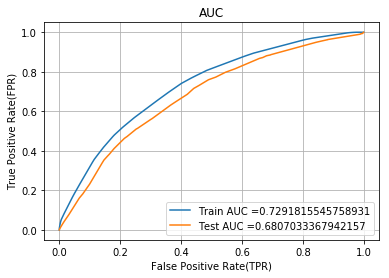

Wall time: 7.33 s


In [38]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

# Creating the classifier with best parameters
classifier = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 73% and 68% respectively

# 4. Visualizing the Tree using Graphviz

### Merging the categorical, numerical and text features names

In [38]:
bow_features_names = []

for a in vectorizer_bow_essay.get_feature_names() :
    bow_features_names.append(a)

for a in vectorizer_bow_title.get_feature_names() :
    bow_features_names.append(a)
    
for a in vectorizer_clean_categories.get_feature_names() :
    bow_features_names.append(a)
    
for a in vectorizer_clean_subcategories.get_feature_names() :
    bow_features_names.append(a)
    
for a in vectorizer_grade_category.get_feature_names() :
    bow_features_names.append(a)
    
for a in vectorizer_school_state.get_feature_names():
    bow_features_names.append(a)
    
for a in vectorizer_teacher_prefix.get_feature_names() :
    bow_features_names.append(a)
    
bow_features_names.append("price")
bow_features_names.append("quantity")
bow_features_names.append("prev_proposed_projects")

len(bow_features_names)

14242

### Creating the classifier with max_depth = 3

In [39]:
from sklearn.tree import DecisionTreeClassifier

# Creating the classifier with best parameters
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(X_tr, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [43]:
# Visualize data
# Running this code will create a pdf file which has the entire tree

import graphviz
from sklearn import tree
from graphviz import Source

dot_data = tree.export_graphviz(classifier, out_file=None, feature_names=bow_features_names,
                                rounded = True, filled = True)

graph = graphviz.Source(dot_data) 
graph.render("Bow tree",view = True)

'Bow tree.pdf'

<img src="Bow tree.jpg">

# 5. Analyzing The Model

In [39]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [40]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.842778286316607
Precision on test set: 0.8487044602384017
Recall on test set: 0.9914683577405857
F1-Score on test set: 0.9145484697723504
Wall time: 108 ms


In [41]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 4758  2667]
 [12626 28988]]
Test confusion matrix
[[ 3461  1998]
 [11271 19321]]


### Function to create the confusion matrix

In [42]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

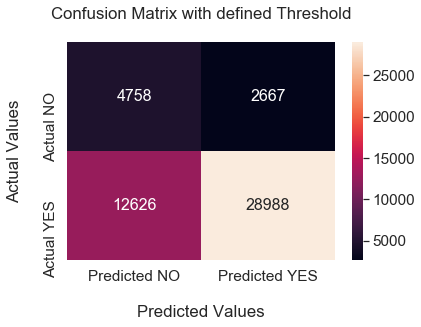

In [44]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

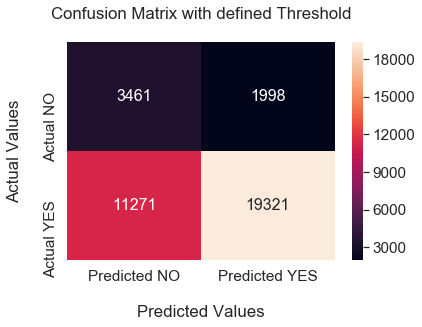

In [45]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 68%
2. The F1_score obtained is 0.9148106317295385

# 6. Analyzing the False Positive Points

### Obtaining the False Positive datapoints

In [46]:
# Checking the y_test and y_test_pred values

print('Test Points : ', y_test[0:3],'\n\nPredicted Points : ', y_test_pred[0:3])
print('\n', "="*120)
print('\nLength of test points and predicted points : ', len(y_test),',', len(y_test_pred))

Test Points :  [1 1 1] 

Predicted Points :  [0.8773764258555133, 0.85625, 0.9367998309025576]


Length of test points and predicted points :  36051 , 36051


In [47]:
# Inorder to get the predicted values we need to call the fuction predict_y()
y_test_predicted = predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)

In [48]:
print(max(y_test_predicted))
print(min(y_test_predicted))
print(len(y_test_predicted))

1
0
36051


In [49]:
# Finding the false positive indexes

false_pos_index = []
fp_count = 0

for i in tqdm(range(len(y_test_predicted))):
    if(y_test[i] == 0 and y_test_predicted[i] == 1):
        false_pos_index.append(i)
        fp_count = fp_count + 1 

100%|███████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 1095327.41it/s]


In [50]:
# We have the false positive indexes

print("Indexes in the false positive classifies points : ", false_pos_index[0:10])
print('\n', "="*120)
print("\nNumber of the false positive classified points : ", fp_count)

Indexes in the false positive classifies points :  [19, 67, 74, 79, 101, 174, 179, 198, 230, 231]


Number of the false positive classified points :  1998


### Finding the words in those indexes

In [51]:
# Shape of the bow
print("Shape of the X_test_essay_bow : ", X_test_essay_bow.shape)
print("Words in vocabulary : ", len(vectorizer_bow_essay.vocabulary_))
print("Type of X_test_essay_bow : ",type(X_test_essay_bow))

Shape of the X_test_essay_bow :  (36051, 12055)
Words in vocabulary :  12055
Type of X_test_essay_bow :  <class 'scipy.sparse.csr.csr_matrix'>


In [52]:
# Converting X_test_essay_bow to dataframe
X_df_bow = pd.DataFrame(X_test_essay_bow.todense())
print("Shape of the bow test data : ", X_df_bow.shape)

# Finding words those specific indexes
X_df_bow = X_df_bow.iloc[false_pos_index,:]
X_df_bow = X_df_bow.reset_index(drop=True)
print("\nShape of the bow false positive points : ", X_df_bow.shape)
X_df_bow.head()

Shape of the bow test data :  (36051, 12055)

Shape of the bow false positive points :  (1998, 12055)


0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   12045  12046  12047  12048  12049  12050  12051  12052  12053  12054  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 12055 columns]

In [53]:
# Collecting the feature names 
feature_name_bow = vectorizer_bow_essay.get_feature_names()

print("Length of the feature_name column wise : ", len(feature_name_bow))
print("\nFeatures : ", feature_name_bow[0:10])

Length of the feature_name column wise :  12055

Features :  ['00', '000', '10', '100', '1000', '100th', '101', '103', '104', '105']


### After having the False positive rows, We now need to find the most frequent appearing features

In [54]:
best_features_indexes = []

for i in range(len(X_df_bow.columns)):
    
    # Finding the total appearance of that specific feature in all the rows
    sum_ = X_df_bow[i].sum()
    
    # Setting threshold of minimum 75 appearances
    if(sum_ >= 75):
        best_features_indexes.append(i)

print("The number of features that appeared minimum 75 times in all the False Positive points : ", len(best_features_indexes))

The number of features that appeared minimum 75 times in all the False Positive points :  605


## NOTE:
- Since in the dense matrix the values are either 0 or 1 (integers) so summing them up row wise will give us a larger value.
- So we are setting a threshold so that we can have those features which cross that threshold

### False Positive words

In [55]:
# False positive words list
fp_words = []

for i in best_features_indexes:
    fp_words.append(str(feature_name_bow[i]))
    
print("False positive words : ", fp_words[0:10])

False positive words :  ['100', '20', '21st', '4th', '5th', '6th', '8th', 'abilities', 'ability', 'able']


# 7. Word Cloud for False Positive Words

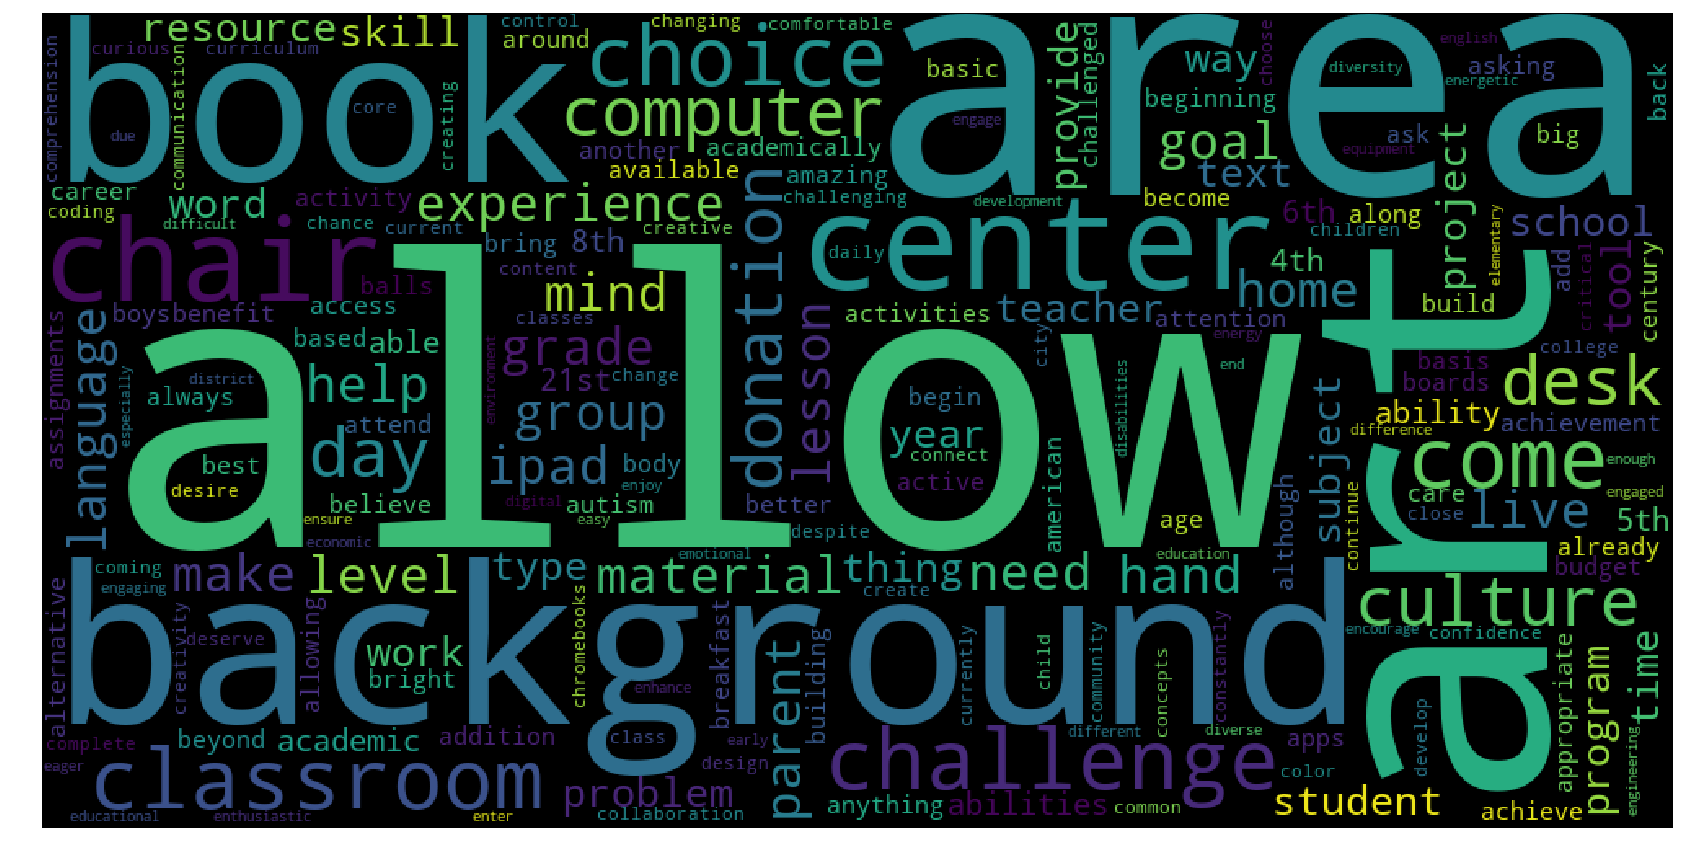

In [56]:
# Reference : https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud

# Conerting list to a single string to generate wordcloud
single_string=(" ").join(fp_words)

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'black').generate(single_string)

# Plotting the figure

plt.figure(figsize=(30,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("Bow_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

# 8. Box plot with the `price` of these `false positive data points`

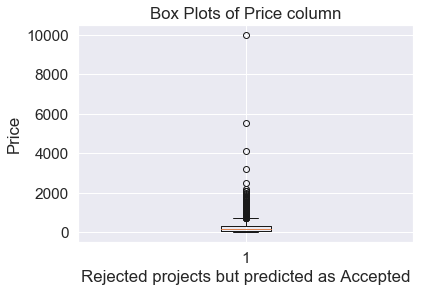

In [57]:
# Creating a dataframe
box_plot_df = pd.DataFrame(X_test['price'])
box_plot_df = box_plot_df.iloc[false_pos_index,:]
box_plot_df = box_plot_df.reset_index(drop=True)

# Plotting
plt.boxplot(box_plot_df.values)
plt.title('Box Plots of Price column')
plt.xlabel('Rejected projects but predicted as Accepted')
plt.ylabel('Price')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.show()

## NOTE:
1. Majority of the projects were rejected but were classified as accepted.
2. As we can see there are lots of outlier points because of which the model couldn't classify them.

## 9. PDF of `teacher_number_of_previously_posted_projects` of these false positive data points

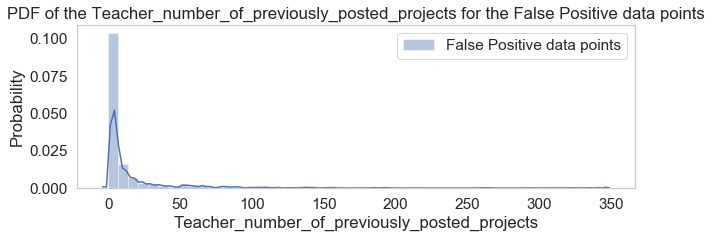

In [58]:
# Creating a dataframe
prev_post_proj_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
prev_post_proj_df = prev_post_proj_df.iloc[false_pos_index,:]
prev_post_proj_df = prev_post_proj_df.reset_index(drop=True)

plt.figure(figsize=(10,3))
sns.distplot(prev_post_proj_df.values, label="False Positive data points")
plt.title('PDF of the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('Probability')
plt.legend()
plt.show()


## NOTE:
1. Majority of the points are at 0 which are 15% of the total data.

# 2. Applying Decision Trees on TF-IDF,<font color='red'> SET 2</font>

<h3><font>Merging the categorical, numerical and text features</font></h3>

In [32]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((X_train_essay_tfidf, X_train_titles_tfidf, X_train_clean_category, X_train_clean_subcategories,
               X_train_project_grade, X_train_school_state, X_train_teacher_prefix,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((X_cv_essay_tfidf, X_cv_titles_tfidf, X_cv_clean_category, X_cv_clean_subcategories,
               X_cv_project_grade, X_cv_school_state, X_cv_teacher_prefix,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((X_test_essay_tfidf, X_test_titles_tfidf, X_test_clean_category, X_test_clean_subcategories,
               X_test_project_grade, X_test_school_state, X_test_teacher_prefix,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()


## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 14205) (49039,)
(24155, 14205) (24155,)
(36051, 14205) (36051,)


### Dimensions of the hstacked features

In [33]:
print('Training DATA\n')
print('ESSAY : ', X_train_essay_tfidf.shape)
print('Title : ', X_train_titles_tfidf.shape)
print('Categorical Data : ', (X_train_clean_category.shape + X_train_clean_subcategories.shape + X_train_project_grade.shape + \
                               X_train_school_state.shape + X_train_teacher_prefix.shape))
print('Numerical Data : ', (X_train_previous_projects.shape + X_train_price.shape + X_train_quantity.shape))

print('\n','='*120)

print('CV DATA\n')
print('ESSAY : ', X_cv_essay_tfidf.shape)
print('Title : ', X_cv_titles_tfidf.shape)
print('Categorical Data : ', (X_cv_clean_category.shape + X_cv_clean_subcategories.shape + X_cv_project_grade.shape + \
                               X_cv_school_state.shape + X_cv_teacher_prefix.shape))
print('Numerical Data : ', (X_cv_previous_projects.shape + X_cv_price.shape + X_cv_quantity.shape))

print('\n','='*120)

print('Test DATA\n')
print('ESSAY : ', X_test_essay_tfidf.shape)
print('Title : ', X_test_titles_tfidf.shape)
print('Categorical Data : ', (X_test_clean_category.shape + X_test_clean_subcategories.shape + X_test_project_grade.shape + \
                               X_test_school_state.shape + X_test_teacher_prefix.shape))
print('Numerical Data : ', (X_test_previous_projects.shape + X_test_price.shape + X_test_quantity.shape))

print('\n','='*120)


Training DATA

ESSAY :  (49039, 12005)
Title :  (49039, 2098)
Categorical Data :  (49039, 9, 49039, 30, 49039, 4, 49039, 51, 49039, 5)
Numerical Data :  (49039, 1, 49039, 1, 49039, 1)

CV DATA

ESSAY :  (24155, 12005)
Title :  (24155, 2098)
Categorical Data :  (24155, 9, 24155, 30, 24155, 4, 24155, 51, 24155, 5)
Numerical Data :  (24155, 1, 24155, 1, 24155, 1)

Test DATA

ESSAY :  (36051, 12005)
Title :  (36051, 2098)
Categorical Data :  (36051, 9, 36051, 30, 36051, 4, 36051, 51, 36051, 5)
Numerical Data :  (36051, 1, 36051, 1, 36051, 1)



## 1. Hyperparamter tuning to find best 'depth' & 'min_samples_split' (Using GridSearchCV)

In [33]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

# creating Decision Trees classifier
classifier = DecisionTreeClassifier()

# Depth and min_sample_split values
parameters = {'max_depth':[1, 5, 10, 50, 100, 300], 'min_samples_split': [5, 10, 50, 100, 300]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

CPU times: user 10.4 s, sys: 200 ms, total: 10.6 s
Wall time: 42min 22s


In [34]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [35]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 300}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 10, 'min_samples_split': 300

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - min_samples_split"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [34]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = min_samples_split

In [48]:
len(train_auc)

30

In [49]:
len(cv_auc)

30

In [50]:
## auc_scores
X_train_auc = train_auc

## auc_scores
X_cv_auc = cv_auc

## min_sample_splits
Y_min_samples_split = pd.Series([5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300,
                                 5, 10, 50, 100, 300,
                                 5, 10, 50, 100, 300], index = X_train_auc)
## max_depth
Z_max_depth = pd.Series([1,1,1,1,1,
                         5,5,5,5,5,
                         10,10,10,10,10,
                         50,50,50,50,50,
                         100,100,100,100,100,
                         300,300,300,300,300], index = X_train_auc)

In [51]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_train_auc, y = Y_min_samples_split, z = Z_max_depth,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_cv_auc, y = Y_min_samples_split, z = Z_max_depth,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - TFIDF',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='Decision-trees-TFIDF')

## NOTE :

1. From the above plots we can conclude that:
    - Values greater than 300 for max_depth overfits the model
    - Values less than 10 for max_depth underfits the model
    - Ideal min_sample_split for the model will be 300

# 3. Now creating the model with best hyperparameters

In [47]:
best_max_depth = 10
best_min_samples_split = 300

In [48]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

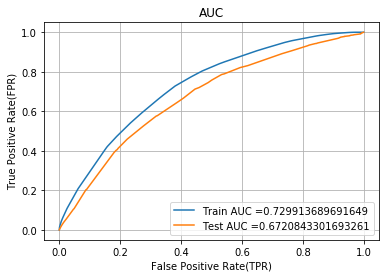

Wall time: 12.2 s


In [49]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

# Creating the classifier with best parameters
classifier = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 73% and 67% respectively

# 4. Visualizing the Tree using Graphviz

### Merging the categorical, numerical and text features names

In [69]:
tfidf_features_names = []

for a in vectorizer_tfidf_essay.get_feature_names() :
    tfidf_features_names.append(a)

for a in vectorizer_tfidf_titles.get_feature_names() :
    tfidf_features_names.append(a)
    
for a in vectorizer_clean_categories.get_feature_names() :
    tfidf_features_names.append(a)
    
for a in vectorizer_clean_subcategories.get_feature_names() :
    tfidf_features_names.append(a)
    
for a in vectorizer_grade_category.get_feature_names() :
    tfidf_features_names.append(a)
    
for a in vectorizer_school_state.get_feature_names():
    tfidf_features_names.append(a)
    
for a in vectorizer_teacher_prefix.get_feature_names() :
    tfidf_features_names.append(a)
    
tfidf_features_names.append("price")
tfidf_features_names.append("quantity")
tfidf_features_names.append("prev_proposed_projects")

len(tfidf_features_names)

14205

### Creating the classifier with max_depth = 3

In [70]:
from sklearn.tree import DecisionTreeClassifier

# Creating the classifier with best parameters
classifier = DecisionTreeClassifier(max_depth=3)
classifier.fit(X_tr, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [72]:
# Visualize data
# Running this code will create a pdf file which has the entire tree

import graphviz
from sklearn import tree
from graphviz import Source

dot_data = tree.export_graphviz(classifier, out_file=None, feature_names=tfidf_features_names,
                                rounded = True, filled = True)

graph = graphviz.Source(dot_data) 
graph.render("TFIDF tree",view = True)

'TFIDF tree.pdf'

<img src = 'TFIDF tree.jpg'>

# 5. Analyzing The Model

In [50]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [51]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.841169454384067
Precision on test set: 0.8521497762419985
Recall on test set: 0.9834597280334728
F1-Score on test set: 0.9131081368175058
Wall time: 110 ms


In [52]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 4600  2825]
 [11325 30289]]
Test confusion matrix
[[ 3338  2121]
 [10820 19772]]


### Function to create the confusion matrix

In [53]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

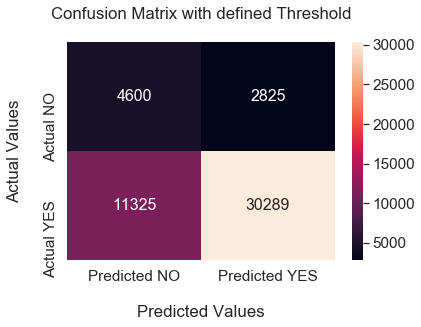

In [55]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

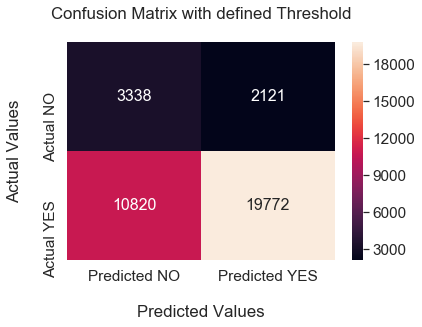

In [56]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 67%
2. The F1_score obtained is 0.9114787028441861

# 6. Analyzing the False Positive Points

### Obtaining the False Positive datapoints

In [57]:
# Checking the y_test and y_test_pred values

print('Test Points : ', y_test[0:3],'\n\nPredicted Points : ', y_test_pred[0:3])
print('\n', "="*120)
print('\nLength of test points and predicted points : ', len(y_test),',', len(y_test_pred))

Test Points :  [1 1 1] 

Predicted Points :  [0.7904761904761904, 0.8809523809523809, 0.7185964912280701]


Length of test points and predicted points :  36051 , 36051


In [58]:
# Inorder to get the predicted values we need to call the fuction predict_y()
y_test_predicted = predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)

print(max(y_test_predicted))
print(min(y_test_predicted))
print(len(y_test_predicted))

1
0
36051


In [59]:
# Finding the false positive indexes

false_pos_index = []
fp_count = 0

for i in tqdm(range(len(y_test_predicted))):
    if(y_test[i] == 0 and y_test_predicted[i] == 1):
        false_pos_index.append(i)
        fp_count = fp_count + 1

100%|████████████████████████████████████████████████████████████████████████| 36051/36051 [00:00<00:00, 602478.52it/s]


In [60]:
# We have the false positive indexes

print("Indexes in the false positive classifies points : ", false_pos_index[0:10])
print('\n', "="*120)
print("\nNumber of the false positive classified points : ", fp_count)

Indexes in the false positive classifies points :  [15, 38, 47, 50, 53, 75, 79, 86, 105, 111]


Number of the false positive classified points :  2121


### Finding the words in those indexes

In [61]:
# Shape of the tfidf
print("Shape of the X_test_essay_tfidf : ", X_test_essay_tfidf.shape)
print("Words in vocabulary : ", len(vectorizer_tfidf_essay.vocabulary_))
print("Type of X_test_essay_tfidf : ",type(X_test_essay_tfidf))

Shape of the X_test_essay_tfidf :  (36051, 12005)
Words in vocabulary :  12005
Type of X_test_essay_tfidf :  <class 'scipy.sparse.csr.csr_matrix'>


In [62]:
# Converting X_test_essay_tfidf to dataframe
X_df_tfidf = pd.DataFrame(X_test_essay_tfidf.todense())
print("Shape of the bow test data : ", X_df_tfidf.shape)

# Finding words those specific indexes
X_df_tfidf = X_df_tfidf.iloc[false_pos_index,:]
X_df_tfidf = X_df_tfidf.reset_index(drop=True)
print("\nShape of the bow false positive points : ", X_df_tfidf.shape)
X_df_tfidf.head()

Shape of the bow test data :  (36051, 12005)

Shape of the bow false positive points :  (2121, 12005)


0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   11995  11996     11997  11998  11999  12000  12001  12002  12003  12004  
0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0  0.111544    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 12005 columns]

In [63]:
# Collecting the feature names 
feature_name_tfidf = vectorizer_tfidf_essay.get_feature_names()

print("Length of the feature_name column wise : ", len(feature_name_tfidf))
print("\nFeatures : ", feature_name_tfidf[0:10])

Length of the feature_name column wise :  12005

Features :  ['00', '000', '10', '100', '1000', '101', '102', '103', '104', '105']


### After having the False positive rows, We now need to find the most frequent appearing features

In [64]:
best_features_indexes = []

for i in range(len(X_df_tfidf.columns)):
    
    # Finding the total appearance of that specific feature in all the rows
    sum_ = X_df_tfidf[i].sum()
    
    # Setting threshold of minimum 10 appearances
    if(sum_ >= 10):
        best_features_indexes.append(i)

print("The number of features that appeared minimum 10 times in all the False Positive points : ", len(best_features_indexes))

The number of features that appeared minimum 10 times in all the False Positive points :  369


## NOTE:
- Since in the dense matrix of the TFIDF vectors the values are in the range of 0 to 1 i.e they are real values, so on adding them we won't get as large values as we got in BOW.
- So we are keeping a lesser threshold compared to BOW vectorization.

### False Positive words

In [65]:
# False positive words list
fp_words = []

for i in best_features_indexes:
    fp_words.append(str(feature_name_tfidf[i]))
    
print("False positive words : ", fp_words[0:10])

False positive words :  ['100', 'ability', 'able', 'academic', 'access', 'achieve', 'active', 'activities', 'activity', 'addition']


# 7. Word Cloud for False Positive Words

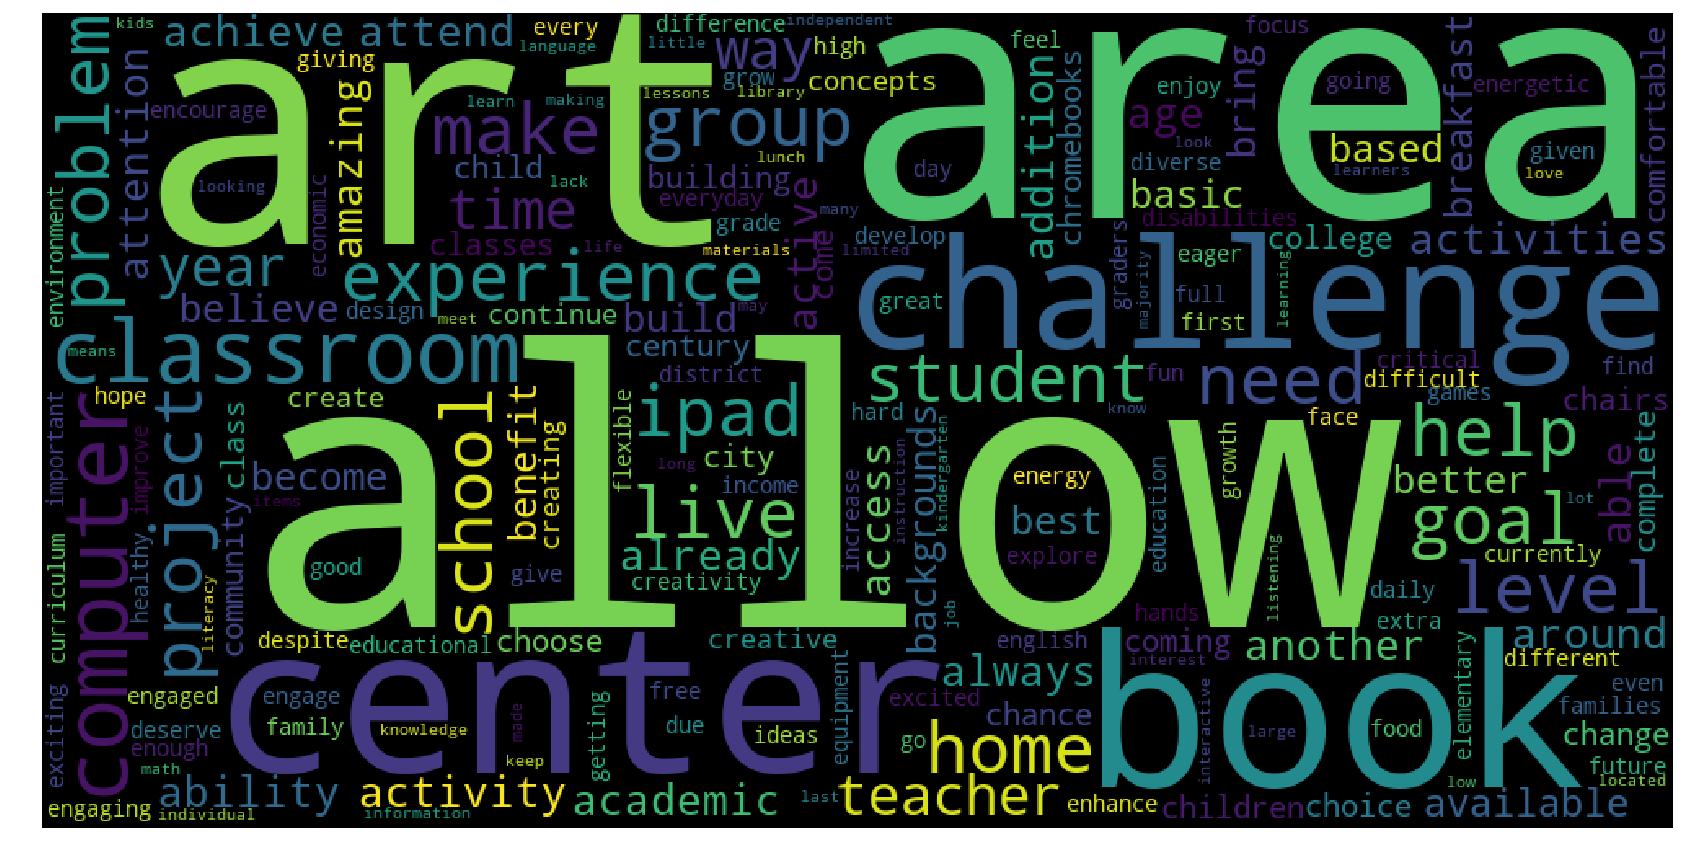

In [66]:
# Reference : https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud

# Conerting list to a single string to generate wordcloud
single_string=(" ").join(fp_words)

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'black').generate(single_string)

# Plotting the figure

plt.figure(figsize=(30,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("TF-IDF_word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

# 8. Box plot with the `price` of these `false positive data points`

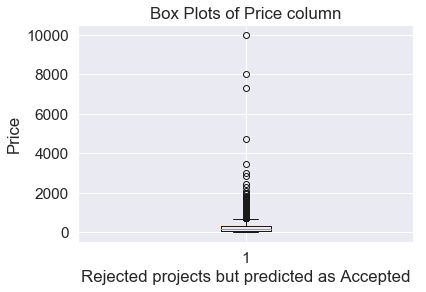

In [67]:
# Creating a dataframe
box_plot_df = pd.DataFrame(X_test['price'])
box_plot_df = box_plot_df.iloc[false_pos_index,:]
box_plot_df = box_plot_df.reset_index(drop=True)

# Plotting
plt.boxplot(box_plot_df.values)
plt.title('Box Plots of Price column')
plt.xlabel('Rejected projects but predicted as Accepted')
plt.ylabel('Price')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.show()

## NOTE:
1. Majority of the projects were rejected but were classified as accepted.
2. As we can see there are lots of outlier points because of which the model couldn't classify them.

## 9. PDF of `teacher_number_of_previously_posted_projects` of these false positive data points

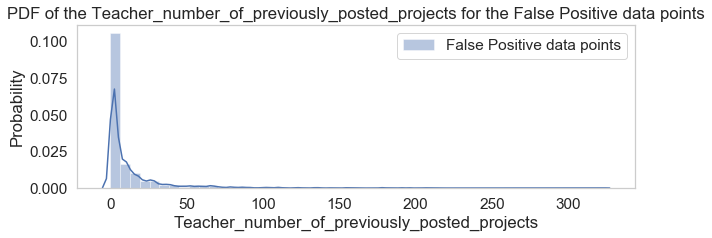

In [68]:
# Creating a dataframe
prev_post_proj_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects'])
prev_post_proj_df = prev_post_proj_df.iloc[false_pos_index,:]
prev_post_proj_df = prev_post_proj_df.reset_index(drop=True)

plt.figure(figsize=(10,3))
sns.distplot(prev_post_proj_df.values, label="False Positive data points")
plt.title('PDF of the Teacher_number_of_previously_posted_projects for the False Positive data points')
plt.xlabel('Teacher_number_of_previously_posted_projects')
plt.ylabel('Probability')
plt.legend()
plt.show()

# 3. Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

<h3><font>Merging the categorical, numerical and text features</font></h3> 

In [34]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((train_w2v_vectors_essays, train_w2v_vectors_titles, X_train_clean_category, X_train_clean_subcategories,
               X_train_project_grade, X_train_school_state, X_train_teacher_prefix,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((cv_w2v_vectors_essays, cv_w2v_vectors_titles, X_cv_clean_category, X_cv_clean_subcategories,
               X_cv_project_grade, X_cv_school_state, X_cv_teacher_prefix,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((test_w2v_vectors_essays, test_w2v_vectors_titles, X_test_clean_category, X_test_clean_subcategories,
               X_test_project_grade, X_test_school_state, X_test_teacher_prefix,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()


## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 702) (49039,)
(24155, 702) (24155,)
(36051, 702) (36051,)


### Dimensions of the hstacked features

In [35]:
print('Training DATA\n')
print('ESSAY : ', train_w2v_vectors_essays.shape)
print('Title : ', train_w2v_vectors_titles.shape)
print('Categorical Data : ', (X_train_clean_category.shape + X_train_clean_subcategories.shape + X_train_project_grade.shape + \
                               X_train_school_state.shape + X_train_teacher_prefix.shape))
print('Numerical Data : ', (X_train_previous_projects.shape + X_train_price.shape + X_train_quantity.shape))

print('\n','='*120)

print('CV DATA\n')
print('ESSAY : ', cv_w2v_vectors_essays.shape)
print('Title : ', cv_w2v_vectors_titles.shape)
print('Categorical Data : ', (X_cv_clean_category.shape + X_cv_clean_subcategories.shape + X_cv_project_grade.shape + \
                               X_cv_school_state.shape + X_cv_teacher_prefix.shape))
print('Numerical Data : ', (X_cv_previous_projects.shape + X_cv_price.shape + X_cv_quantity.shape))

print('\n','='*120)

print('Test DATA\n')
print('ESSAY : ', test_w2v_vectors_essays.shape)
print('Title : ', test_w2v_vectors_titles.shape)
print('Categorical Data : ', (X_test_clean_category.shape + X_test_clean_subcategories.shape + X_test_project_grade.shape + \
                               X_test_school_state.shape + X_test_teacher_prefix.shape))
print('Numerical Data : ', (X_test_previous_projects.shape + X_test_price.shape + X_test_quantity.shape))

print('\n','='*120)


Training DATA

ESSAY :  (49039, 300)
Title :  (49039, 300)
Categorical Data :  (49039, 9, 49039, 30, 49039, 4, 49039, 51, 49039, 5)
Numerical Data :  (49039, 1, 49039, 1, 49039, 1)

CV DATA

ESSAY :  (24155, 300)
Title :  (24155, 300)
Categorical Data :  (24155, 9, 24155, 30, 24155, 4, 24155, 51, 24155, 5)
Numerical Data :  (24155, 1, 24155, 1, 24155, 1)

Test DATA

ESSAY :  (36051, 300)
Title :  (36051, 300)
Categorical Data :  (36051, 9, 36051, 30, 36051, 4, 36051, 51, 36051, 5)
Numerical Data :  (36051, 1, 36051, 1, 36051, 1)



## 1. Hyperparamter tuning to find best 'depth' & 'min_samples_split' (Using GridSearchCV)

In [35]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

# creating Decision Trees classifier
classifier = DecisionTreeClassifier()

# Depth and min_sample_split values
parameters = {'max_depth':[1, 5, 10, 50, 100, 300], 'min_samples_split': [5, 10, 50, 100, 300]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

CPU times: user 1min, sys: 687 ms, total: 1min 1s
Wall time: 2h 10min 20s


In [37]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=300,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [38]:
clf.best_params_

{'max_depth': 10, 'min_samples_split': 300}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 10, 'min_samples_split': 300

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - min_samples_split"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [43]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = min_samples_split

In [54]:
len(train_auc)

30

In [55]:
len(cv_auc)

30

In [56]:
## auc_scores
X_train_auc = train_auc

## auc_scores
X_cv_auc = cv_auc

## min_sample_splits
Y_min_samples_split = pd.Series([5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300,
                                 5, 10, 50, 100, 300,
                                 5, 10, 50, 100, 300], index = X_train_auc)
## max_depth
Z_max_depth = pd.Series([1,1,1,1,1,
                         5,5,5,5,5,
                         10,10,10,10,10,
                         50,50,50,50,50,
                         100,100,100,100,100,
                         300,300,300,300,300], index = X_train_auc)

In [57]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_train_auc, y = Y_min_samples_split, z = Z_max_depth,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_cv_auc, y = Y_min_samples_split, z = Z_max_depth,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - AVGW2V',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='Decision-trees-AVGW2V')

## NOTE :

1. From the above plots we can conclude that:
    - Values greater than 300 for max_depth overfits the model
    - Values less than 10 for max_depth underfits the model
    - Ideal min_sample_split for the model will be 300

# 3. Now creating the model with best hyperparameters

In [35]:
best_max_depth = 10
best_min_samples_split = 300

In [36]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

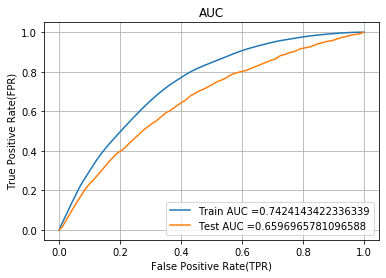

CPU times: user 1min 2s, sys: 268 ms, total: 1min 2s
Wall time: 1min 1s


In [37]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

# Creating the classifier with best parameters
classifier = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 74% and 66% respectively

# 4. Analyzing The Model

In [38]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    # print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [39]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.83329172561094
Precision on test set: 0.8559307309162516
Recall on test set: 0.9661676255230126
F1-Score on test set: 0.9077145138505006
CPU times: user 185 ms, sys: 76.3 ms, total: 261 ms
Wall time: 155 ms


In [40]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 4740  2685]
 [11154 30460]]
Test confusion matrix
[[ 3118  2341]
 [ 9913 20679]]


### Function to create the confusion matrix

In [41]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

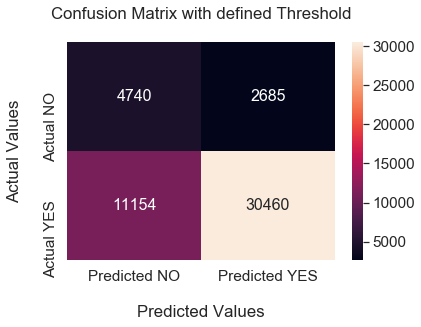

In [43]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

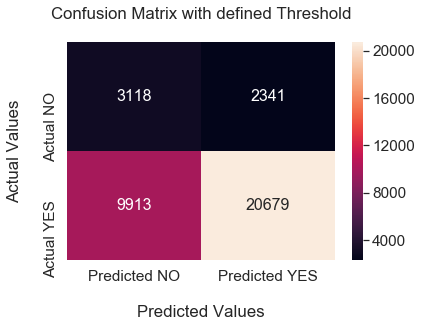

In [44]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 66%
2. The F1_score obtained is 0.9077145138505006

### Since feature names can't be exracted from AVG-W2V, we can't analyse the false positive points 

# 4. Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

<h3><font>Merging the categorical, numerical and text features</font></h3> 

In [33]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((train_tfidf_w2v_essays, train_tfidf_w2v_titles, X_train_clean_category, X_train_clean_subcategories,
               X_train_project_grade, X_train_school_state, X_train_teacher_prefix,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((cv_tfidf_w2v_essays, cv_tfidf_w2v_titles, X_cv_clean_category, X_cv_clean_subcategories,
               X_cv_project_grade, X_cv_school_state, X_cv_teacher_prefix,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((test_tfidf_w2v_essays, test_tfidf_w2v_titles, X_test_clean_category, X_test_clean_subcategories,
               X_test_project_grade, X_test_school_state, X_test_teacher_prefix,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()


## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 702) (49039,)
(24155, 702) (24155,)
(36051, 702) (36051,)


### Dimensions of the hstacked features

In [34]:
print('Training DATA\n')
print('ESSAY : ', train_tfidf_w2v_essays.shape)
print('Title : ', train_tfidf_w2v_titles.shape)
print('Categorical Data : ', (X_train_clean_category.shape + X_train_clean_subcategories.shape + X_train_project_grade.shape + \
                               X_train_school_state.shape + X_train_teacher_prefix.shape))
print('Numerical Data : ', (X_train_previous_projects.shape + X_train_price.shape + X_train_quantity.shape))

print('\n','='*120)

print('CV DATA\n')
print('ESSAY : ', cv_tfidf_w2v_essays.shape)
print('Title : ', cv_tfidf_w2v_titles.shape)
print('Categorical Data : ', (X_cv_clean_category.shape + X_cv_clean_subcategories.shape + X_cv_project_grade.shape + \
                               X_cv_school_state.shape + X_cv_teacher_prefix.shape))
print('Numerical Data : ', (X_cv_previous_projects.shape + X_cv_price.shape + X_cv_quantity.shape))

print('\n','='*120)

print('Test DATA\n')
print('ESSAY : ', test_tfidf_w2v_essays.shape)
print('Title : ', test_tfidf_w2v_titles.shape)
print('Categorical Data : ', (X_test_clean_category.shape + X_test_clean_subcategories.shape + X_test_project_grade.shape + \
                               X_test_school_state.shape + X_test_teacher_prefix.shape))
print('Numerical Data : ', (X_test_previous_projects.shape + X_test_price.shape + X_test_quantity.shape))

print('\n','='*120)


Training DATA

ESSAY :  (49039, 300)
Title :  (49039, 300)
Categorical Data :  (49039, 9, 49039, 30, 49039, 4, 49039, 51, 49039, 5)
Numerical Data :  (49039, 1, 49039, 1, 49039, 1)

CV DATA

ESSAY :  (24155, 300)
Title :  (24155, 300)
Categorical Data :  (24155, 9, 24155, 30, 24155, 4, 24155, 51, 24155, 5)
Numerical Data :  (24155, 1, 24155, 1, 24155, 1)

Test DATA

ESSAY :  (36051, 300)
Title :  (36051, 300)
Categorical Data :  (36051, 9, 36051, 30, 36051, 4, 36051, 51, 36051, 5)
Numerical Data :  (36051, 1, 36051, 1, 36051, 1)



## 1. Hyperparamter tuning to find best 'depth' & 'min_samples_split' (Using GridSearchCV)

In [35]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

# creating Decision Trees classifier
classifier = DecisionTreeClassifier()

# Depth and min_sample_split values
parameters = {'max_depth':[1, 5, 10, 50, 100, 300], 'min_samples_split': [5, 10, 50, 100, 300]}

# Finding the best parameter using gridsearchcv and 5-folds
clf = GridSearchCV(classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_tr, y_train)

# Finding the auc scores 
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

CPU times: user 25.1 s, sys: 805 ms, total: 25.9 s
Wall time: 1h 55min 1s


In [36]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
clf.best_params_

{'max_depth': 5, 'min_samples_split': 50}

## NOTE:
    - As we can see, the best estimators estimated by the GridSearchCV are:
        
        - 'max_depth': 5, 'min_samples_split': 50

# 2. Visualizing the AUC score of both Train and CV data

#### Reference : https://plot.ly/python/3d-scatter-plots/

## NOTE:
    - Now we have 3 Dimensions: 
        
        - "auc_score of both train and cv data"
        - "Hyperparameter - max_depth"
        - "Hyperparameter - min_samples_split"
        
    - In order to visualise the auc_scores and the hyperparameters, We have to plot a 3D plot using plotly 

In [30]:
## Importing the plotly library and setting up the credentials

import plotly
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='manas234das', api_key='aEIT60nE5xrOuVln8ZhY')

import plotly.graph_objs as go

### Defining the 3 axis of the plot:
    - X-AXIS = auc_score
    - Y-AXIS = max_depth
    - Z-AXIS = min_samples_split

In [33]:
len(train_auc)

30

In [34]:
len(cv_auc)

30

In [35]:
## auc_scores
X_train_auc = train_auc

## auc_scores
X_cv_auc = cv_auc

## min_sample_splits
Y_min_samples_split = pd.Series([5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300, 
                                 5, 10, 50, 100, 300,
                                 5, 10, 50, 100, 300,
                                 5, 10, 50, 100, 300], index = X_train_auc)
## max_depth
Z_max_depth = pd.Series([1,1,1,1,1,
                         5,5,5,5,5,
                         10,10,10,10,10,
                         50,50,50,50,50,
                         100,100,100,100,100,
                         300,300,300,300,300], index = X_train_auc)

In [37]:
py.init_notebook_mode(connected=True)

## Defining traces
trace1 = go.Scatter3d(x = X_train_auc, y = Y_min_samples_split, z = Z_max_depth,
                     marker = dict(size=5, color='#3077e8', colorscale='Viridis'),
                     line = dict(color='#9bc1ff', width=2),
                     name = "Train AUC")

trace2 = go.Scatter3d(x = X_cv_auc, y = Y_min_samples_split, z = Z_max_depth,
                     marker = dict(size=5, color='#f9801d', colorscale='RdBu'),
                     line = dict(color='#ffb67a', width=2),
                     name = "CV AUC")

## defining data for the figure
trace_data = [trace1, trace2]

## Defining the layout of the figure
layout = dict(width=800, height=700, autosize=True, 
              title='Train vs CV Error plot - TFIDF_W2V',
              scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                    zerolinecolor='rgb(255, 255, 255)',
                                    showbackground=True,
                                    backgroundcolor='rgb(230, 230,230)'),
                         camera=dict(up=dict(x=0, y=0, z=1),
                                     eye=dict(x=-1.7428, y=1.0707, z=0.7100,)),
                         aspectratio = dict(x=1, y=1, z=0.7),
                         aspectmode = 'manual'))

# Defining the figure
fig = dict(data = trace_data, layout = layout)

# Plotting the figure
py.iplot(fig, filename='Decision-trees-TFIDFW2V')

## NOTE :

1. From the above plots we can conclude that:
    - Values greater than 100 for max_depth overfits the model
    - Values less than 10 for max_depth underfits the model
    - Ideal min_sample_split for the model will be 100

# 3. Now creating the model with best hyperparameters

In [50]:
best_max_depth = 10
best_min_samples_split = 100

In [51]:
# Reference : Assignment_SAMPLE_SOLUTION

def batch_predict(clf, data):
    
    """
    This function returns the predicted probability scores
    """
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

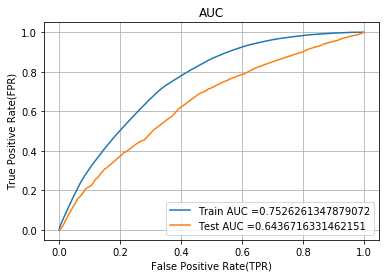

CPU times: user 1min 14s, sys: 375 ms, total: 1min 15s
Wall time: 1min 14s


In [52]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

# Creating the classifier with best parameters
classifier = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the Predict confidence scores for test and train values
y_train_pred = batch_predict(classifier, X_tr)    
y_test_pred = batch_predict(classifier, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(TPR)")
plt.ylabel("True Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 75% and 65% respectively

# 4. Analyzing The Model

In [53]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict_y(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    # print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [54]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8272724751047128
Precision on test set: 0.8543381518862162
Recall on test set: 0.9601529811715481
F1-Score on test set: 0.9041601896172257
CPU times: user 348 ms, sys: 60.2 ms, total: 408 ms
Wall time: 232 ms


In [56]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_y(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_y(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 4831  2594]
 [11220 30394]]
Test confusion matrix
[[ 3033  2426]
 [10032 20560]]


### Function to create the confusion matrix

In [57]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict_y(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

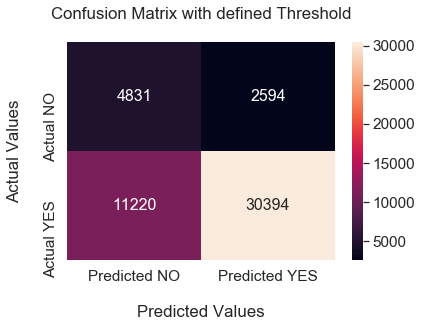

In [59]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

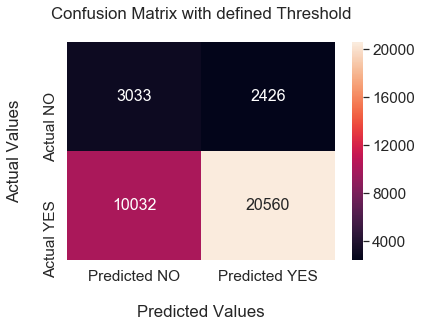

In [60]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 65%
2. The F1_score obtained is 0.9041601896172257

### Since feature names can't be exracted from AVG-W2V, we can't analyse the false positive points 

# [ Task - 2 ] Select 5k best features from features of <font color='red'> SET 2</font>

<h3><font>Merging the categorical, numerical and text features</font></h3>

In [32]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# https://stackoverflow.com/questions/54226138/constructing-sparse-csr-matrix-directly-vs-using-coo-tocsr-scipy
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)

from scipy.sparse import hstack

# Training data
X_tr = hstack((X_train_essay_tfidf, X_train_titles_tfidf, X_train_clean_category, X_train_clean_subcategories,
               X_train_project_grade, X_train_school_state, X_train_teacher_prefix,
               X_train_previous_projects, X_train_price, X_train_quantity)).tocsr()
# CV data
X_cr = hstack((X_cv_essay_tfidf, X_cv_titles_tfidf, X_cv_clean_category, X_cv_clean_subcategories,
               X_cv_project_grade, X_cv_school_state, X_cv_teacher_prefix,
               X_cv_previous_projects, X_cv_price, X_cv_quantity)).tocsr()
# Test data
X_te = hstack((X_test_essay_tfidf, X_test_titles_tfidf, X_test_clean_category, X_test_clean_subcategories,
               X_test_project_grade, X_test_school_state, X_test_teacher_prefix,
               X_test_previous_projects, X_test_price, X_test_quantity)).tocsr()


## Print the final data matrix

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(49039, 14220) (49039,)
(24155, 14220) (24155,)
(36051, 14220) (36051,)


## Making the model to obtain the 5K best features

In [33]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

# Creating the classifier with best parameters
classifier = DecisionTreeClassifier()
classifier.fit(X_tr, y_train)

Wall time: 3min 6s


In [34]:
classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Computing the Feature importances

In [35]:
# Reference : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

imp_features = classifier.tree_.compute_feature_importances()

In [36]:
print("Size of the Important features martix : ", imp_features.shape)
print("\nSome Important features : ", imp_features[0:25])

Size of the Important features martix :  (14220,)

Some Important features :  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00061889
 0.         0.         0.         0.         0.00054161 0.
 0.         0.         0.         0.00010581 0.         0.
 0.        ]


## NOTE:
- In order to get the important features we need to transpose it -> Convert rows to columns
- We have to capture those features which have values more than 0 after summing up it's rows

In [37]:
# Creating a dataframe

features_df = pd.DataFrame(imp_features)

print("Shape before Transpose : ", features_df.shape)

features_df = np.transpose(features_df)

print("\nShape after transpose : ", features_df.shape)

features_df.head()

Shape before Transpose :  (14220, 1)

Shape after transpose :  (1, 14220)


0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   14210  14211  14212     14213     14214     14215   14216     14217  \
0    0.0    0.0    0.0  0.000402  0.000275  0.001237  0.0004  0.011766   

      14218     14219  
0  0.030995  0.020474  

[1 rows x 14220 columns]

### `Now we have 14270 features from which we have to find the best ones`

In [38]:
# Capturing the indexes of the features which have some importance i.e. which are not 0

imp_indexes = []

for i in tqdm(range(len(imp_features))):
    
    sum_ = features_df[i].sum()
    
    if(sum_ > 0.0):
        imp_indexes.append(i)

print("\nNumber of important features : ", len(imp_indexes))
print("\nImportant feature indexes are : ", imp_indexes[:15])

100%|██████████████████████████████████████████████████████████████████████████| 14220/14220 [00:02<00:00, 5384.84it/s]



Number of important features :  2527

Important feature indexes are :  [11, 16, 21, 42, 45, 49, 50, 52, 65, 66, 68, 73, 74, 75, 76]


### After calculations, we have just 2527 features which have values greater than 0 or are the important features

### We have to separate these important features from the train matrix and test matrix

In [39]:
# Convert the sparse matrix to a dense matrix to separate the important features

X_train_df = X_tr.todense()
X_test_df = X_te.todense()

# Creating dataframes for indexing
X_train_df = pd.DataFrame(X_train_df)
X_test_df = pd.DataFrame(X_test_df)

print("Shape before separating the important features (train) : ", X_train_df.shape)
print("Shape before separating the important features (test) : ", X_test_df.shape)

X_train_final = X_train_df.iloc[:,imp_indexes]
X_test_final = X_test_df.iloc[:,imp_indexes]

print("Shape after separating the important features (train) : ", X_train_final.shape)
print("Shape after separating the important features (test) : ", X_test_final.shape)

Shape before separating the important features (train) :  (49039, 14220)
Shape before separating the important features (test) :  (36051, 14220)
Shape after separating the important features (train) :  (49039, 2527)
Shape after separating the important features (test) :  (36051, 2527)


In [40]:
# To save memory
del X_train_df, X_test_df

## Using Logistic regression and applying these features

### 1. Hyper paramter tuning to find best α (alpha) (Using GridSearchCV)

In [53]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://stackoverflow.com/questions/52640386/how-do-i-solve-the-future-warning-min-groups-self-n-splits-warning-in
# https://stackoverflow.com/questions/48643181/please-what-is-the-meaning-of-the-deprecation-warning-message

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc

# creating logistic regression classifier
classifier = SGDClassifier(loss='log', max_iter = 100000, tol = 1e-3)

# Lambda values
parameters = {'alpha':[0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000001]}

# Finding the best parameter using gridsearchcv and 10-folds
clf = GridSearchCV(classifier, parameters, cv=10, scoring='roc_auc', return_train_score=True, n_jobs = -1)
clf.fit(X_train_final, y_train)


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']


# We use log(alpha) values so as to get a more distinguishable graph because log is monotonous function 
# and it won't affect our results

plt.plot(np.log(parameters['alpha']), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(parameters['alpha']),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(parameters['alpha']), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(parameters['alpha']),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(np.log(parameters['alpha']), train_auc, label='Train AUC points')
plt.scatter(np.log(parameters['alpha']), cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha α: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

CPU times: user 8.64 s, sys: 465 ms, total: 9.1 s
Wall time: 5min 51s


In [54]:
clf.best_estimator_

SGDClassifier(alpha=5e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=100000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Now creating the model with best α

In [60]:
# From the error plot we choose α such that, we will have maximum AUC on cv data and gap between the train and cv is less

# Here we are choosing the best_α based on GridSearchCV results

best_α = 0.0001

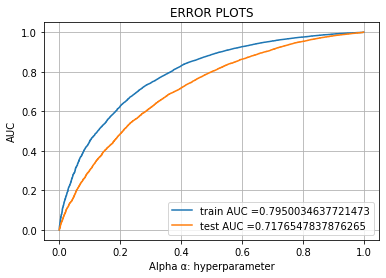

CPU times: user 1.27 s, sys: 28.1 ms, total: 1.3 s
Wall time: 898 ms


In [61]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier

# Creating the classifier with best α
classifier = SGDClassifier(loss='log', alpha = best_α, max_iter = 100000, tol = 1e-3)
classifier.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

# Getting the predicted probability scores for test and train values
y_train_pred = classifier.predict_proba(X_tr)[:,1]   
y_test_pred = classifier.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha α: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## NOTE:
    - As we can see from the graph.The AUC curve is lower for the test set than the train set.
    - The AUC scores for the Train and Test data are : 79% and 71% respectively
    - We choose the α value equal to 0.0001 because it has maximum AUC on the CV data

In [62]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def predict(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    # print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

from sklearn.metrics import classification_report

y_pred_new = classifier.predict(X_te)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred_new, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.52      0.03      0.05      5459
     class 1       0.85      1.00      0.92     30592

    accuracy                           0.85     36051
   macro avg       0.69      0.51      0.48     36051
weighted avg       0.80      0.85      0.79     36051



In [64]:
%%time
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = classifier.predict(X_te)
print("Accuracy on test set: {}".format(accuracy_score(y_test, y_pred_new)))
print("Precision on test set: {}".format(precision_score(y_test, y_pred_new)))
print("Recall on test set: {}".format(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: {}".format(f1_score(y_test, y_pred_new)))


Accuracy on test set: 0.8489084907492164
Precision on test set: 0.8514129189143863
Recall on test set: 0.9957178347280334
F1-Score on test set: 0.9179285509801263
CPU times: user 39.5 ms, sys: 77 µs, total: 39.6 ms
Wall time: 38.3 ms


In [65]:
from sklearn.metrics import confusion_matrix

print("="*120)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, te_thresholds, train_fpr, train_tpr)))
print("="*120)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr)))

Train confusion matrix
[[ 5365  2060]
 [11490 30124]]
Test confusion matrix
[[ 3512  1947]
 [ 9681 20911]]


### Function to create the confusion matrix

In [66]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def get_confusion_matrix(y_tr_ts, y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr):
    
    """Function to get heatmap confusion matrix"""
    
    # Creating the confusion matrix dataframe
    df_cm = pd.DataFrame(confusion_matrix(y_tr_ts, predict(y_tr_ts_pred, tr_ts_thresholds, tr_ts_fpr, tr_ts_tpr))
                         , range(2),range(2))
    
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    
    plt.title('Confusion Matrix with defined Threshold\n ')
    
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Confusion Matrix on train data

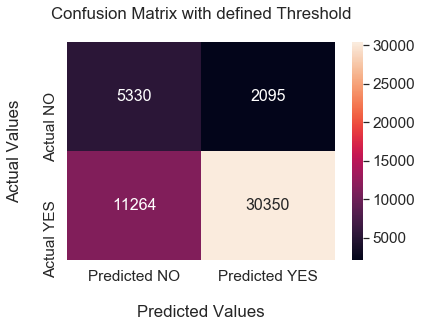

In [68]:
get_confusion_matrix(y_train, y_train_pred, tr_thresholds, train_fpr, train_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

### Confusion Matrix on test data

In [69]:
get_confusion_matrix(y_test, y_test_pred, te_thresholds, test_fpr, test_tpr)
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values\n')
plt.show()

## NOTE:
1. The model predicts the test set correctly with a AUC score of 71%
2. The F1_score obtained is 0.9177457816414621
3. The alpha value that we got after GridSearchCV is 0.0001

# CONCLUSION

In [2]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameters(max depth,min samples split)", "Train AUC", "Test AUC"]

x.add_row(["BOW", "Decision Trees","(10, 100)", 0.73, 0.68])
x.add_row(["TFIDF", "Decision Trees", "(10, 300)", 0.73, 0.67])
x.add_row(["AVG W2V", "Decision Trees", "(10, 300)", 0.74, 0.66])
x.add_row(["TFIDF W2V", "Decision Trees", "(10, 100)", 0.75, 0.65])
x.add_row(["TFIDF-5k Features", "Logistic Regression", "Alpha(α)-0.0001", 0.79, 0.71])

print(x)

+-------------------+---------------------+----------------------------------------------+-----------+----------+
|     Vectorizer    |        Model        | Hyperparameters(max depth,min samples split) | Train AUC | Test AUC |
+-------------------+---------------------+----------------------------------------------+-----------+----------+
|        BOW        |    Decision Trees   |                  (10, 100)                   |    0.73   |   0.68   |
|       TFIDF       |    Decision Trees   |                  (10, 300)                   |    0.73   |   0.67   |
|      AVG W2V      |    Decision Trees   |                  (10, 300)                   |    0.74   |   0.66   |
|     TFIDF W2V     |    Decision Trees   |                  (10, 100)                   |    0.75   |   0.65   |
| TFIDF-5k Features | Logistic Regression |               Alpha(α)-0.0001                |    0.79   |   0.71   |
+-------------------+---------------------+---------------------------------------------

1. Since there were 3 dimensions to plot, so I had to use plotly and had to plot the train and cv results along with the max_depth and min_samples_split.
2. The above table shows us that the model is performing well on training data for all vectorizers but with the test data it somewhat struggling.
3. For the 5K Best features [SET-5] I used logistic regression to classify the points. The results are better than any of the vectorizers.
4. Since the vocabulary for the AVG W2V and TFIDF W2V can't be obtained, so we could't analyse the false positive points and the word cloud for those vectorizers.